# 🌟 Cálculo del Stop Loss óptimo en ATAS usando ATR y ticks

## 🔹 Fundamento general

Cuando operas en ATAS con futuros como el MES, NQ o GC, una forma robusta de colocar tu Stop Loss (SL) es basarlo en la volatilidad reciente usando el indicador **ATR (Average True Range)**. El ATR mide el rango medio de movimiento del precio en puntos. Para aplicar este valor a tu estrategia, debes convertirlo a **ticks**, que es la unidad real de ejecución del mercado.

---

## 📊 ATR Period: ¿Por qué 14 o 21?

| Periodo | Razonamiento                                                                                                                  |
| ------- | ----------------------------------------------------------------------------------------------------------------------------- |
| **14**  | Valor clásico de Welles Wilder. Equilibra sensibilidad y estabilidad. Ideal para intradía.                                    |
| **21**  | Mayor robustez estadística. Suaviza picos de volatilidad. Recomendado para entornos ruidosos o estrategias más conservadoras. |

> 🔍 Cuanto **menor el periodo**, más **reactivo** (escálping). Cuanto **mayor**, más **suave** (swing o protección frente a ruido).

---

## 📈 Multiplier: ¿Por qué entre 1.2 y 2?

| Multiplier | Interpretación                                                |
| ---------- | ------------------------------------------------------------- |
| **1.2**    | SL ajustado, agresivo. Para entradas de alta precisión.       |
| **1.5**    | SL equilibrado, protege sin alejarse demasiado.               |
| **2.0**    | SL amplio. Úfil en entornos volátiles o para evitar barridas. |

> 🧠 El multiplicador adapta el SL a la **volatilidad actual**, permitiendo evitar stops falsos sin alejar demasiado el riesgo.

---

## 🔢 Cálculo del SL en ticks

La fórmula depende del activo. A continuación, el detalle:

### 📅 MES (Micro E-mini S\&P 500)

* Tick mínimo: **0.25 puntos**
* 1 punto = **4 ticks**

```text
SL_ticks = ATR × 4 × Multiplier
```

### 📅 NQ (Nasdaq E-mini)

* Tick mínimo: **0.25 puntos**
* 1 punto = **4 ticks**

```text
SL_ticks = ATR × 4 × Multiplier
```

### 📅 GC (Gold Futures)

* Tick mínimo: **0.10 puntos**
* 1 punto = **10 ticks**

```text
SL_ticks = ATR × 10 × Multiplier
```

---

## 📊 Ejemplo práctico

Supongamos:

* ATR = 7.5 puntos
* Multiplier = 1.5

### Para cada activo:

**MES o NQ:**

```text
SL = 7.5 × 4 × 1.5 = 45 ticks
```

**GC:**

```text
SL = 7.5 × 10 × 1.5 = 112.5 ticks
```

---

## 📊 Tabla resumen

| Activo  | Tick mínimo | Ticks por punto | Fórmula SL en ticks     |
| ------- | ----------- | --------------- | ----------------------- |
| **MES** | 0.25        | 4               | `ATR × 4 × Multiplier`  |
| **NQ**  | 0.25        | 4               | `ATR × 4 × Multiplier`  |
| **GC**  | 0.10        | 10              | `ATR × 10 × Multiplier` |

---

> ✅ Esta metodología estandariza el riesgo, lo adapta a la volatilidad real y mejora la consistencia del sistema de trading.





In [105]:
import yfinance as yf
import pandas as pd
import os
from datetime import datetime, timedelta

# ========================================
# Parte 1: Descarga diaria y guardado único por ticker
# ========================================

carpeta_diaria = "data/1d"
os.makedirs(carpeta_diaria, exist_ok=True)

tickers = ["SPY", "QQQ", "GLD"]
dfs_diarios = {}

for ticker in tickers:
    print(f"\U0001F4E5 Descargando datos diarios de {ticker}...")
    df = yf.download(ticker, start="2010-01-01", end="2025-01-01", interval="1d", progress=False)

    df = df[['Open', 'High', 'Low', 'Close', 'Volume']].copy()
    df.reset_index(inplace=True)
    df['Ticker'] = ticker
    df['Year'] = df['Date'].dt.year
    df['Month'] = df['Date'].dt.month
    df['Day'] = df['Date'].dt.day

    dfs_diarios[ticker] = df

    ruta_archivo = os.path.join(carpeta_diaria, f"{ticker.lower()}_1d.parquet")
    df.to_parquet(ruta_archivo, index=False)
    print(f"✅ Guardado: {ruta_archivo} ({df.shape[0]} filas)")

📥 Descargando datos diarios de SPY...
✅ Guardado: data/1d/spy_1d.parquet (3774 filas)
📥 Descargando datos diarios de QQQ...
✅ Guardado: data/1d/qqq_1d.parquet (3774 filas)
📥 Descargando datos diarios de GLD...
✅ Guardado: data/1d/gld_1d.parquet (3774 filas)


In [106]:
# ========================================
# Parte 2: Descarga de datos por minuto y guardado único con timestamp
# ========================================

def descargar_y_guardar_1m_archivo_unico(ticker, dias=7, carpeta="data/1m"):
    os.makedirs(carpeta, exist_ok=True)

    hoy = datetime.today()
    fecha_inicio = hoy - timedelta(days=dias)
    fecha_fin = hoy

    print(f"\U0001F4E5 Descargando {ticker} desde {fecha_inicio.strftime('%Y-%m-%d')} hasta {fecha_fin.strftime('%Y-%m-%d')}...")

    df = yf.download(ticker, start=fecha_inicio, end=fecha_fin, interval="1m", progress=False)

    if df.empty:
        print(f"⚠️ No hay datos descargados para {ticker}.")
        return

    df.reset_index(inplace=True)
    df['Ticker'] = ticker
    df['DateOnly'] = df['Datetime'].dt.date
    df['Year'] = df['Datetime'].dt.year
    df['Month'] = df['Datetime'].dt.month
    df['Day'] = df['Datetime'].dt.day
    df['Hour'] = df['Datetime'].dt.hour
    df['Minute'] = df['Datetime'].dt.minute

    timestamp = hoy.strftime("%Y-%m-%d_%H%M")
    archivo = os.path.join(carpeta, f"{ticker.lower()}_1m_{timestamp}.parquet")
    df.to_parquet(archivo, index=False)

    print(f"✅ Archivo guardado: {archivo} ({df.shape[0]} filas).")

# Ejecutar para cada ticker
for ticker in tickers:
    descargar_y_guardar_1m_archivo_unico(ticker)

📥 Descargando SPY desde 2025-05-21 hasta 2025-05-28...
✅ Archivo guardado: data/1m/spy_1m_2025-05-28_1205.parquet (1402 filas).
📥 Descargando QQQ desde 2025-05-21 hasta 2025-05-28...
✅ Archivo guardado: data/1m/qqq_1m_2025-05-28_1205.parquet (1402 filas).
📥 Descargando GLD desde 2025-05-21 hasta 2025-05-28...
✅ Archivo guardado: data/1m/gld_1m_2025-05-28_1205.parquet (1402 filas).


In [117]:
# ========================================
# Parte 3: Limpieza y verificación de columnas del archivo diario
# ========================================

In [116]:
import pandas as pd
import os

tickers = ["SPY", "QQQ", "GLD"]
carpeta = "data/1d"

def limpiar_columnas(df):
    """Convierte columnas como ('Close', 'SPY') → 'Close' y ('Date', '') → 'Date'"""
    if isinstance(df.columns, pd.MultiIndex):
        df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]
    df.columns = [str(col).replace("(", "").replace(")", "").replace("'", "").replace(",", "").strip() for col in df.columns]
    return df

def analizar_archivo(ticker):
    path = os.path.join(carpeta, f"{ticker.lower()}_1d.parquet")
    print(f"\n🔍 Explorando {ticker}...")

    df = pd.read_parquet(path)
    df = limpiar_columnas(df)

    print("📋 Columnas:", df.columns.tolist())
    print(f"✅ Filas: {len(df)}")

    if "Date" in df.columns:
        print(f"📅 Rango de fechas: {df['Date'].min()} → {df['Date'].max()}")
    else:
        print("⚠️ Columna 'Date' no encontrada.")

    print("❓ Nulos:")
    print(df.isnull().sum())
    print("📊 Estadísticas:")
    display(df.describe(include='all'))
    print("🧪 Primeras filas:")
    display(df.head())

# Ejecutar análisis para cada archivo
for ticker in tickers:
    analizar_archivo(ticker)







🔍 Explorando SPY...
📋 Columnas: ['Date', 'Open SPY', 'High SPY', 'Low SPY', 'Close SPY', 'Volume SPY', 'Ticker', 'Year', 'Month', 'Day']
✅ Filas: 3774
📅 Rango de fechas: 2010-01-04 00:00:00 → 2024-12-31 00:00:00
❓ Nulos:
Date          0
Open SPY      0
High SPY      0
Low SPY       0
Close SPY     0
Volume SPY    0
Ticker        0
Year          0
Month         0
Day           0
dtype: int64
📊 Estadísticas:


,Date,Open SPY,High SPY,Low SPY,Close SPY,Volume SPY,Ticker,Year,Month,Day
count,3774,3774.000000,3774.000000,3774.000000,3774.000000,3.774000e+03,3774,3774.000000,3774.000000,3774.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,SPY,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,3774,NaN,NaN,NaN
mean,2017-07-01 21:42:38.346582016,247.912037,249.240095,246.465056,247.951908,1.118051e+08,NaN,2016.998675,6.544780,15.721516
min,2010-01-04 00:00:00,78.728045,78.964739,77.216265,78.033226,2.027000e+07,NaN,2010.000000,1.000000,1.000000
25%,2013-10-02 06:00:00,138.616162,139.151500,138.270057,138.785526,6.614835e+07,NaN,2013.000000,4.000000,8.000000
50%,2017-07-01 12:00:00,214.083357,214.662655,213.256952,214.013100,9.190805e+07,NaN,2017.000000,7.000000,16.000000
75%,2021-03-31 18:00:00,362.745597,366.156114,359.486432,363.376320,1.360184e+08,NaN,2021.000000,10.000000,23.000000
max,2024-12-31 00:00:00,603.835093,605.206363,603.169379,603.954346,7.178287e+08,NaN,2024.000000,12.000000,31.000000


🧪 Primeras filas:


,Date,Open SPY,High SPY,Low SPY,Close SPY,Volume SPY,Ticker,Year,Month,Day
0,2010-01-04,85.041910,85.813847,84.391060,85.768440,118944600,SPY,2010,1,4
1,2010-01-05,85.715470,86.033326,85.405178,85.995483,111579900,SPY,2010,1,5
2,2010-01-06,85.912221,86.267919,85.844111,86.056015,116074400,SPY,2010,1,6
3,2010-01-07,85.897108,86.525256,85.654932,86.419304,131091100,SPY,2010,1,7
4,2010-01-08,86.192253,86.744721,86.018191,86.706879,126402800,SPY,2010,1,8



🔍 Explorando QQQ...
📋 Columnas: ['Date', 'Open QQQ', 'High QQQ', 'Low QQQ', 'Close QQQ', 'Volume QQQ', 'Ticker', 'Year', 'Month', 'Day']
✅ Filas: 3774
📅 Rango de fechas: 2010-01-04 00:00:00 → 2024-12-31 00:00:00
❓ Nulos:
Date          0
Open QQQ      0
High QQQ      0
Low QQQ       0
Close QQQ     0
Volume QQQ    0
Ticker        0
Year          0
Month         0
Day           0
dtype: int64
📊 Estadísticas:


,Date,Open QQQ,High QQQ,Low QQQ,Close QQQ,Volume QQQ,Ticker,Year,Month,Day
count,3774,3774.000000,3774.000000,3774.000000,3774.000000,3.774000e+03,3774,3774.000000,3774.000000,3774.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,QQQ,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,3774,NaN,NaN,NaN
mean,2017-07-01 21:42:38.346582016,178.623108,179.890260,177.237951,178.657265,4.522598e+07,NaN,2016.998675,6.544780,15.721516
min,2010-01-04 00:00:00,37.267540,37.520468,36.610119,37.171589,7.079300e+06,NaN,2010.000000,1.000000,1.000000
25%,2013-10-02 06:00:00,71.565265,72.009817,71.313501,71.735962,2.710672e+07,NaN,2013.000000,4.000000,8.000000
50%,2017-07-01 12:00:00,133.901200,134.178028,133.134043,133.702385,3.882705e+07,NaN,2017.000000,7.000000,16.000000
75%,2021-03-31 18:00:00,283.287870,286.355052,280.767243,283.741707,5.616305e+07,NaN,2021.000000,10.000000,23.000000
max,2024-12-31 00:00:00,534.699072,537.480547,532.475997,536.503540,2.882004e+08,NaN,2024.000000,12.000000,31.000000


🧪 Primeras filas:


,Date,Open QQQ,High QQQ,Low QQQ,Close QQQ,Volume QQQ,Ticker,Year,Month,Day
0,2010-01-04,40.407314,40.546860,40.354983,40.485806,62822800,QQQ,2010,1,4
1,2010-01-05,40.459642,40.555580,40.259045,40.485806,62935600,QQQ,2010,1,5
2,2010-01-06,40.468380,40.599202,40.180564,40.241615,96033000,QQQ,2010,1,6
3,2010-01-07,40.302660,40.354991,40.049732,40.267773,77094100,QQQ,2010,1,7
4,2010-01-08,40.180556,40.599194,40.058453,40.599194,88886600,QQQ,2010,1,8



🔍 Explorando GLD...
📋 Columnas: ['Date', 'Open GLD', 'High GLD', 'Low GLD', 'Close GLD', 'Volume GLD', 'Ticker', 'Year', 'Month', 'Day']
✅ Filas: 3774
📅 Rango de fechas: 2010-01-04 00:00:00 → 2024-12-31 00:00:00
❓ Nulos:
Date          0
Open GLD      0
High GLD      0
Low GLD       0
Close GLD     0
Volume GLD    0
Ticker        0
Year          0
Month         0
Day           0
dtype: int64
📊 Estadísticas:


,Date,Open GLD,High GLD,Low GLD,Close GLD,Volume GLD,Ticker,Year,Month,Day
count,3774,3774.000000,3774.000000,3774.000000,3774.000000,3.774000e+03,3774,3774.000000,3774.000000,3774.000000
unique,NaN,NaN,NaN,NaN,NaN,NaN,1,NaN,NaN,NaN
top,NaN,NaN,NaN,NaN,NaN,NaN,GLD,NaN,NaN,NaN
freq,NaN,NaN,NaN,NaN,NaN,NaN,3774,NaN,NaN,NaN
mean,2017-07-01 21:42:38.346582016,146.629269,147.277809,145.932268,146.625911,9.643175e+06,NaN,2016.998675,6.544780,15.721516
min,2010-01-04 00:00:00,100.919998,100.989998,100.230003,100.500000,1.436500e+06,NaN,2010.000000,1.000000,1.000000
25%,2013-10-02 06:00:00,120.610001,121.059998,120.199997,120.642500,5.790925e+06,NaN,2013.000000,4.000000,8.000000
50%,2017-07-01 12:00:00,138.215004,138.955002,137.720001,138.245003,8.077650e+06,NaN,2017.000000,7.000000,16.000000
75%,2021-03-31 18:00:00,168.399998,169.127502,167.524998,168.455006,1.154675e+07,NaN,2021.000000,10.000000,23.000000
max,2024-12-31 00:00:00,256.760010,257.709991,255.910004,257.500000,9.380420e+07,NaN,2024.000000,12.000000,31.000000


🧪 Primeras filas:


,Date,Open GLD,High GLD,Low GLD,Close GLD,Volume GLD,Ticker,Year,Month,Day
0,2010-01-04,109.820000,110.139999,109.309998,109.800003,16224100,GLD,2010,1,4
1,2010-01-05,109.879997,110.389999,109.260002,109.699997,14213100,GLD,2010,1,5
2,2010-01-06,110.709999,111.769997,110.410004,111.510002,24981900,GLD,2010,1,6
3,2010-01-07,111.070000,111.290001,110.620003,110.820000,13609800,GLD,2010,1,7
4,2010-01-08,111.519997,111.580002,110.260002,111.370003,15894600,GLD,2010,1,8


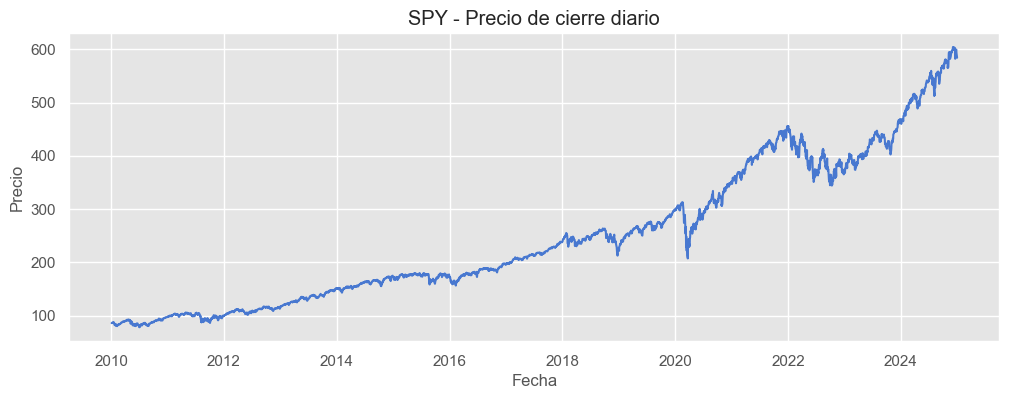

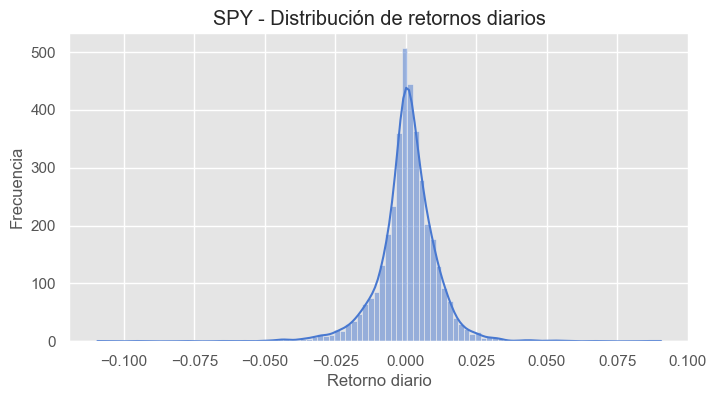

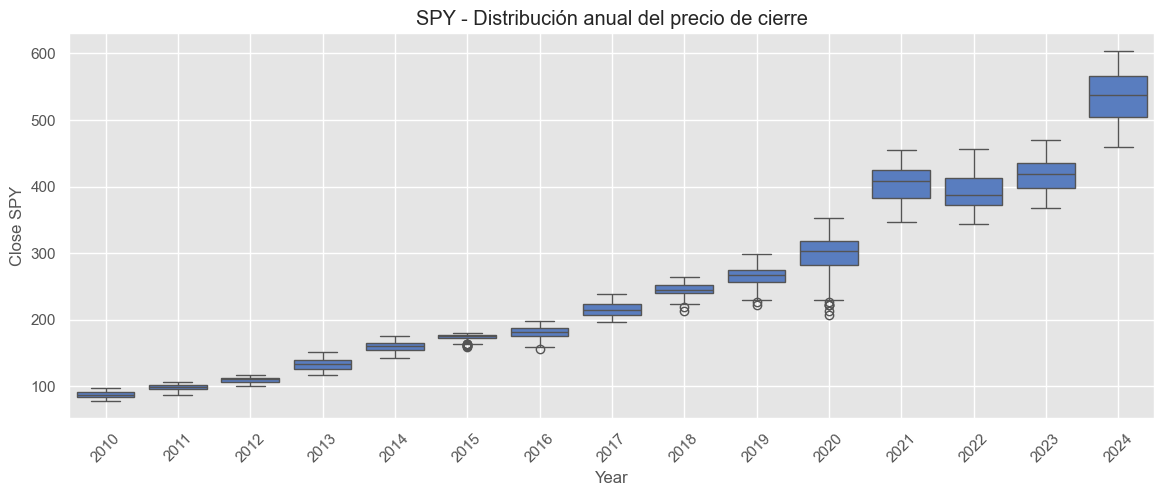

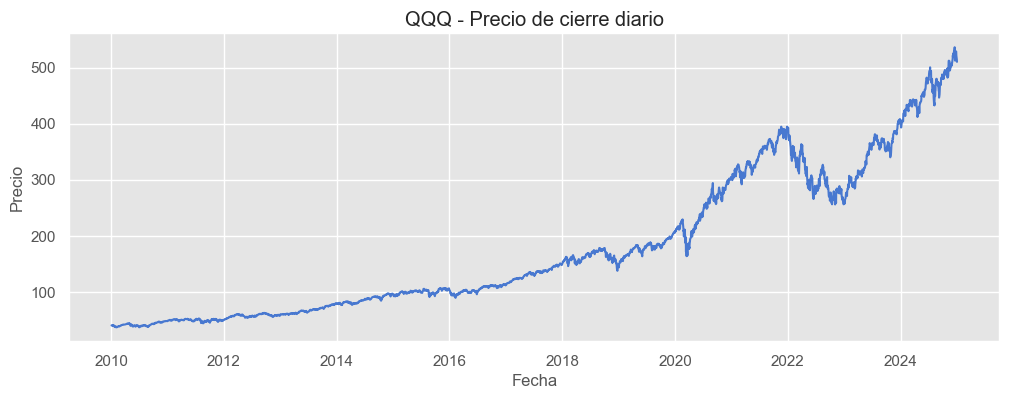

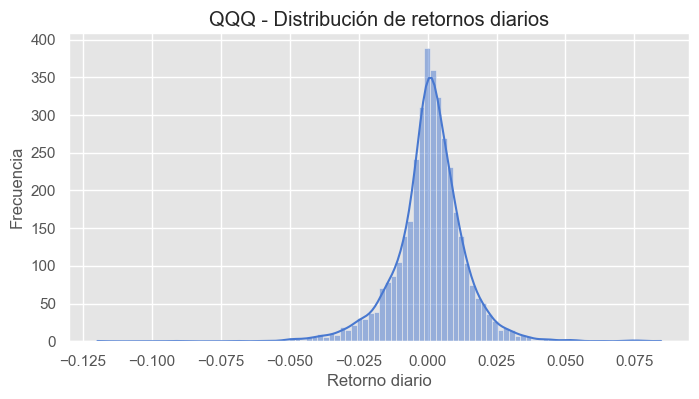

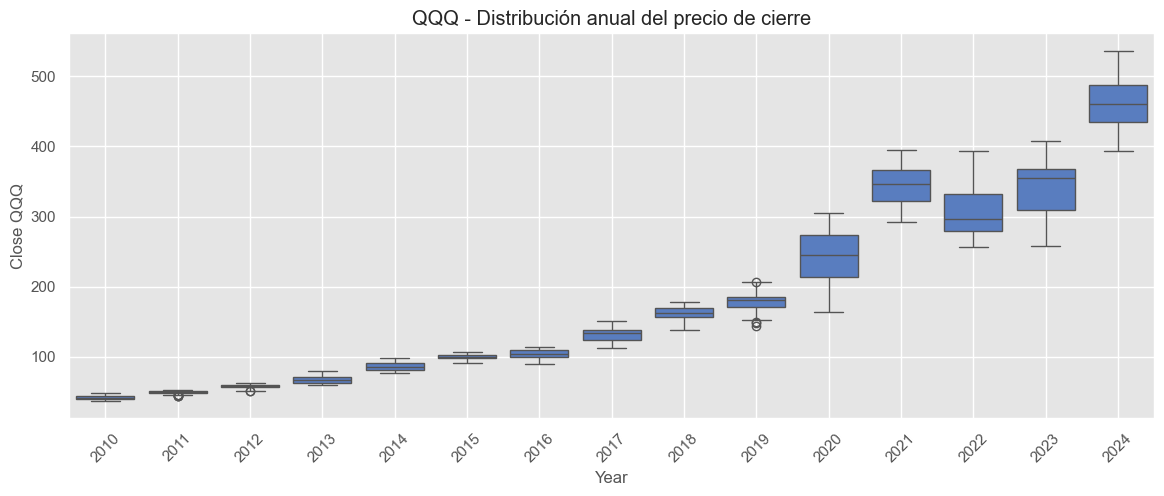

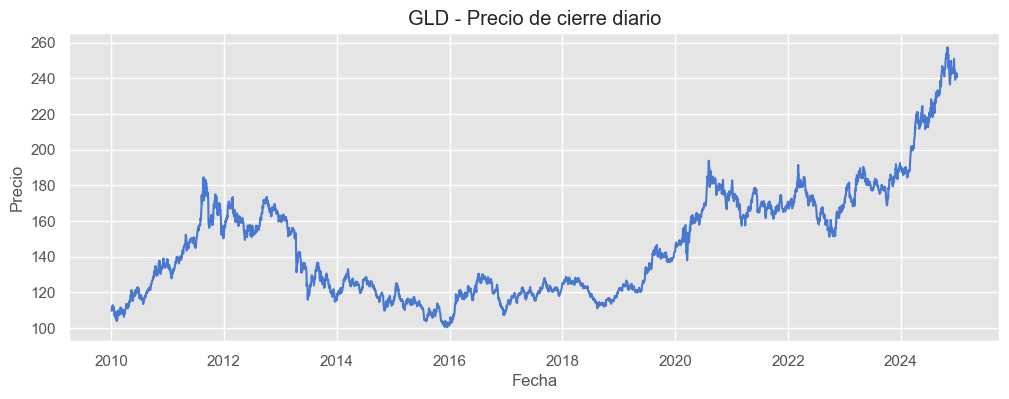

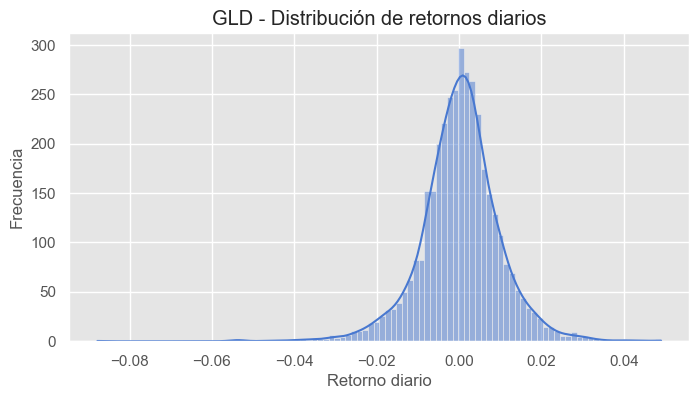

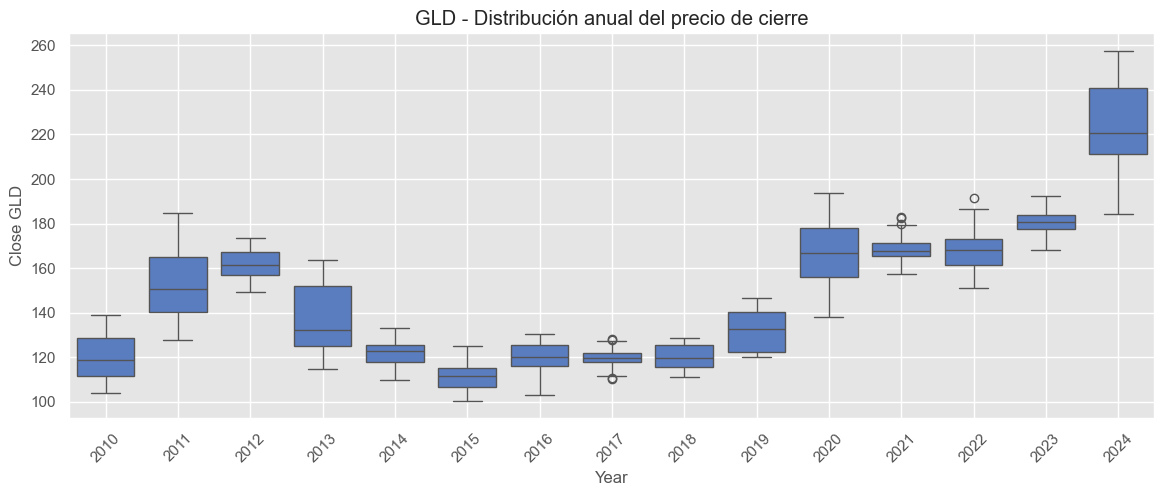

In [118]:
import matplotlib.pyplot as plt
import seaborn as sns

# Para gráficos bonitos
plt.style.use('ggplot')
sns.set_palette('muted')

def eda_visual(df, ticker):
    # Renombrar columnas clave para trabajar con ellas
    close_col = f'Close {ticker}'
    date_col = 'Date'
    
    # Asegurarse de que la columna de fecha es datetime
    df[date_col] = pd.to_datetime(df[date_col])
    df = df.sort_values(by=date_col)

    # Calcular retornos diarios
    df['Return'] = df[close_col].pct_change()

    # 1. Evolución del precio
    plt.figure(figsize=(12, 4))
    plt.plot(df[date_col], df[close_col])
    plt.title(f'{ticker} - Precio de cierre diario')
    plt.xlabel('Fecha')
    plt.ylabel('Precio')
    plt.grid(True)
    plt.show()

    # 2. Histograma de retornos
    plt.figure(figsize=(8, 4))
    sns.histplot(df['Return'].dropna(), bins=100, kde=True)
    plt.title(f'{ticker} - Distribución de retornos diarios')
    plt.xlabel('Retorno diario')
    plt.ylabel('Frecuencia')
    plt.show()

    # 3. Boxplot anual de precios de cierre
    df['Year'] = df[date_col].dt.year
    plt.figure(figsize=(14, 5))
    sns.boxplot(x='Year', y=close_col, data=df)
    plt.title(f'{ticker} - Distribución anual del precio de cierre')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.show()

# Aplicar EDA visual a cada archivo
for ticker in tickers:
    df = pd.read_parquet(os.path.join(carpeta, f"{ticker.lower()}_1d.parquet"))
    df = limpiar_columnas(df)
    eda_visual(df, ticker)



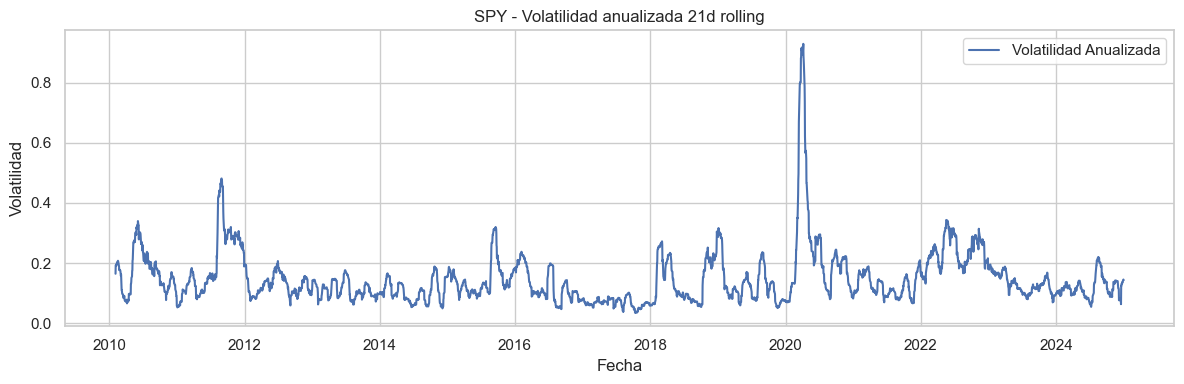

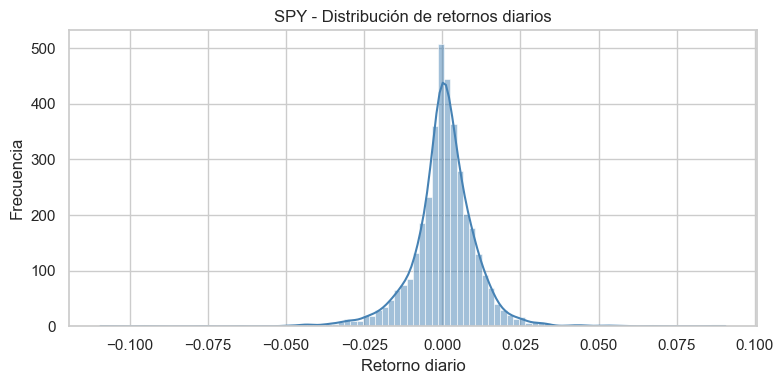


⬆️ Estadísticas descriptivas de retornos:
count    3773.000000
mean        0.000567
std         0.010741
min        -0.109424
25%        -0.003709
50%         0.000682
75%         0.005790
max         0.090603
Name: Return, dtype: float64


In [120]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# === Configuración ===
ticker = "SPY"
archivo = f"data/1d/{ticker.lower()}_1d.parquet"

# === Lectura y limpieza ===
df = pd.read_parquet(archivo)

# Aplanar MultiIndex si existe
df.columns = [col[0] if isinstance(col, tuple) else col for col in df.columns]

# Normalizar nombre columna fecha (por si acaso)
df.rename(columns={
    "('Date', '')": "Date",
    "Date": "Date"
}, inplace=True)

# Verificamos si la columna Date existe
if "Date" not in df.columns:
    raise KeyError("❌ No se encontró columna 'Date' en el DataFrame")

# Asegurar formato datetime
df["Date"] = pd.to_datetime(df["Date"])

# Ordenar y resetear
if not df["Date"].is_monotonic_increasing:
    df = df.sort_values("Date")
df.reset_index(drop=True, inplace=True)

# Normalizar nombre columnas OHLCV
for col in df.columns:
    if "Open" in col: df.rename(columns={col: "Open"}, inplace=True)
    if "High" in col: df.rename(columns={col: "High"}, inplace=True)
    if "Low" in col: df.rename(columns={col: "Low"}, inplace=True)
    if "Close" in col: df.rename(columns={col: "Close"}, inplace=True)
    if "Volume" in col: df.rename(columns={col: "Volume"}, inplace=True)

# === Cálculo de retornos ===
df["Return"] = df["Close"].pct_change()
df.dropna(inplace=True)

# === Cálculo de volatilidad ===
df["VolatilidadDiaria"] = df["Return"].rolling(window=21).std()
df["VolatilidadAnualizada"] = df["VolatilidadDiaria"] * (252 ** 0.5)

# === Plots ===
plt.figure(figsize=(12, 4))
plt.plot(df["Date"], df["VolatilidadAnualizada"], label="Volatilidad Anualizada")
plt.title(f"{ticker} - Volatilidad anualizada 21d rolling")
plt.xlabel("Fecha")
plt.ylabel("Volatilidad")
plt.legend()
plt.tight_layout()
plt.show()

# === Histograma de retornos ===
plt.figure(figsize=(8, 4))
sns.histplot(df["Return"], bins=100, kde=True, color="steelblue")
plt.title(f"{ticker} - Distribución de retornos diarios")
plt.xlabel("Retorno diario")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()

# === Estadísticas ===
print("\n⬆️ Estadísticas descriptivas de retornos:")
print(df["Return"].describe())



📌 Estadísticas de retornos logarítmicos:
count    3773.000000
mean        0.000509
std         0.010772
min        -0.115887
25%        -0.003716
50%         0.000681
75%         0.005773
max         0.086731
Name: ret_log, dtype: float64

📎 Asimetría: -0.7212224780911725
📎 Curtosis : 11.527559776699015
📎 Autocorrelación de retornos absolutos (1 lag): 0.3120605840841689
📎 Autocorrelación de retornos (1 lag): -0.09852430902132395


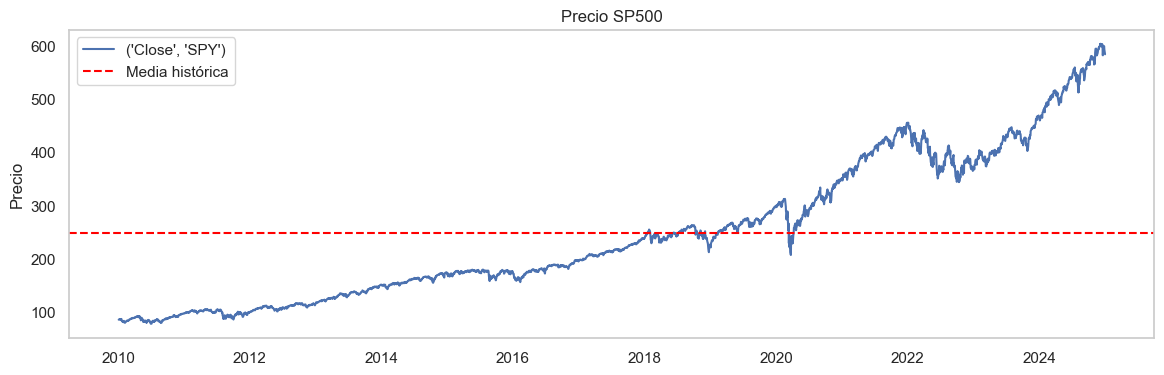

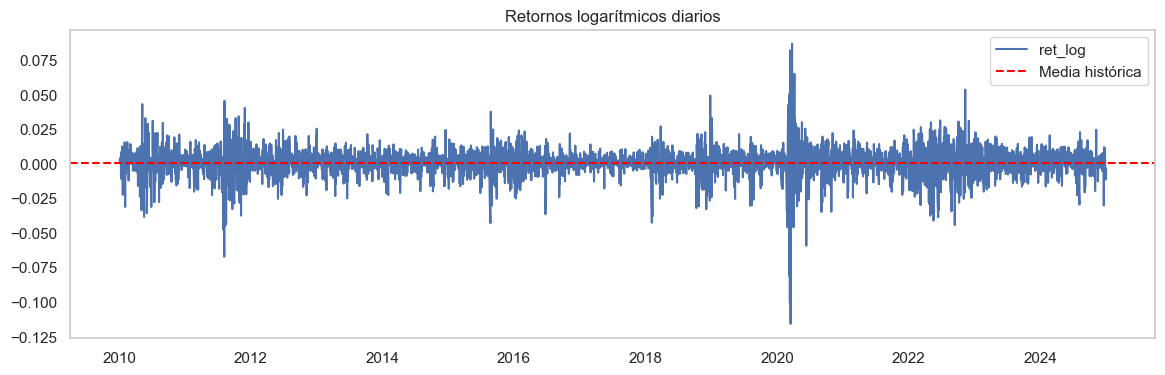

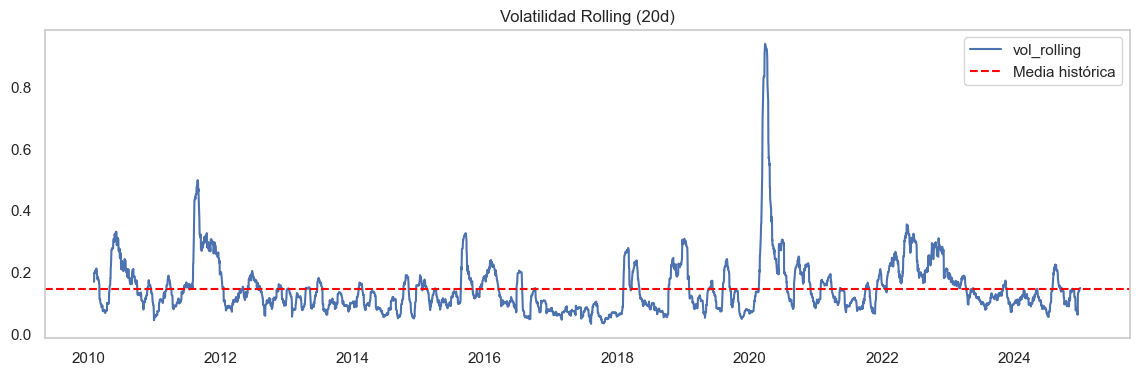

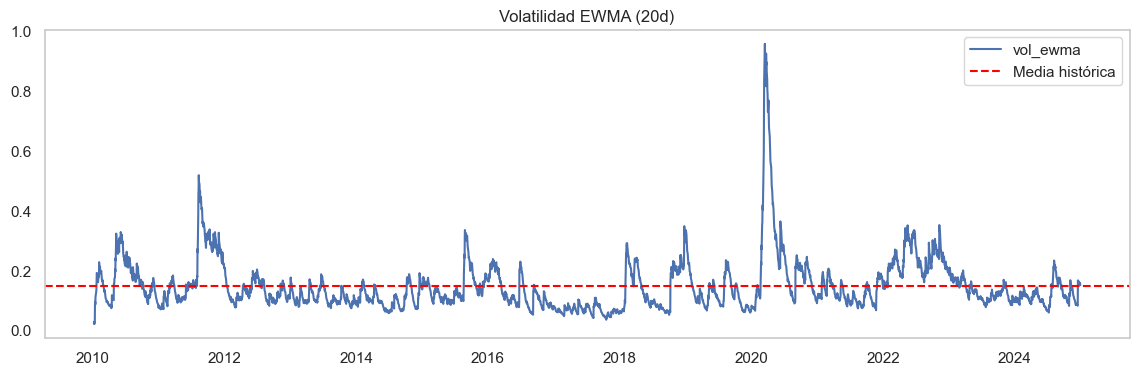

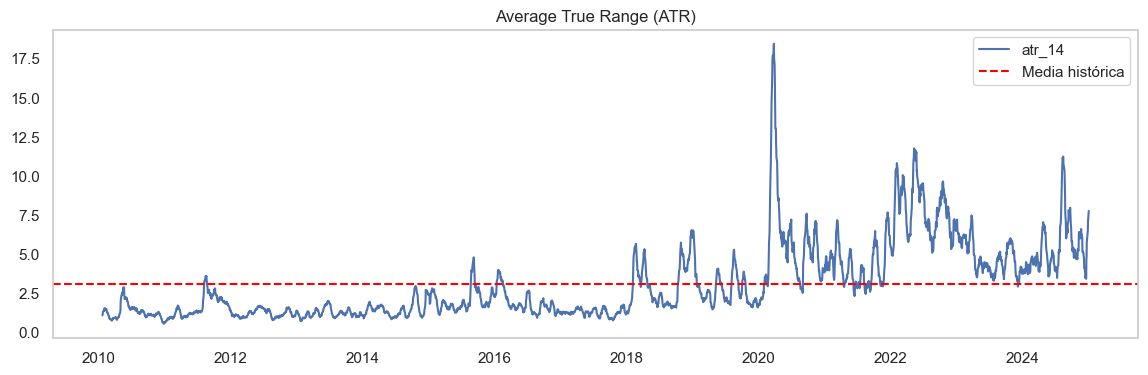

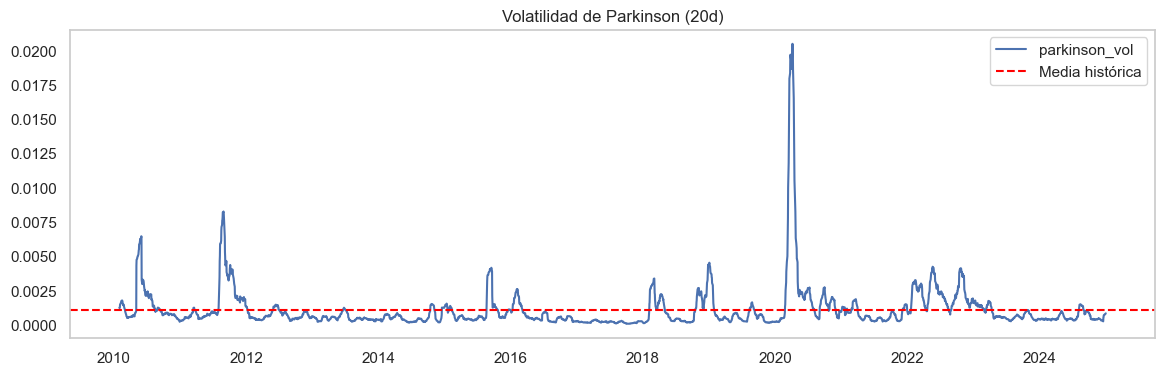

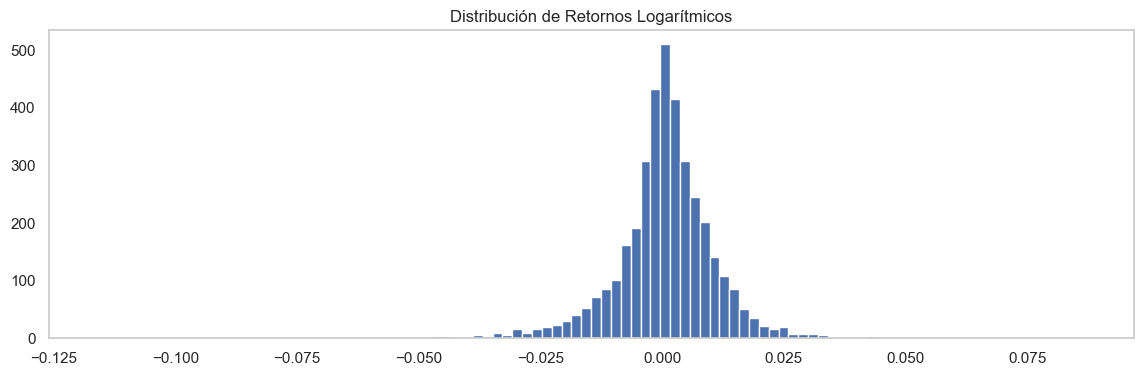

In [127]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import skew, kurtosis

# 📂 Ruta del archivo
file_path = "data/1d/spy_1d.parquet"

# 📥 Leer y limpiar
df = pd.read_parquet(file_path)

# 🔧 Aplanar columnas si hay MultiIndex
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [' '.join(filter(None, map(str, col))).strip() for col in df.columns]

# 🔍 Buscar columna de fecha y renombrar
date_col = [col for col in df.columns if 'date' in col.lower()]
if not date_col:
    raise KeyError("❌ No se encontró ninguna columna de fecha.")
df.rename(columns={date_col[0]: 'Date'}, inplace=True)

# ⏱️ Convertir y establecer índice
df['Date'] = pd.to_datetime(df['Date'])
df.set_index('Date', inplace=True)

# 🔍 Identificar columnas clave automáticamente
close_col = [col for col in df.columns if 'close' in col.lower()][0]
high_col = [col for col in df.columns if 'high' in col.lower()][0]
low_col  = [col for col in df.columns if 'low' in col.lower()][0]

# 🧮 Cálculos de retornos
df['ret_pct'] = df[close_col].pct_change()
df['ret_log'] = np.log(df[close_col] / df[close_col].shift(1))
df['ret_abs'] = df[close_col].diff()

# 📈 Volatilidad rolling (20 días)
df['vol_rolling'] = df['ret_log'].rolling(window=20).std() * np.sqrt(252)

# 📉 Volatilidad EWMA
df['vol_ewma'] = df['ret_log'].ewm(span=20).std() * np.sqrt(252)

# 🔺 ATR (Average True Range)
df['tr'] = np.maximum(df[high_col] - df[low_col],
                      np.maximum(abs(df[high_col] - df[close_col].shift(1)),
                                 abs(df[low_col] - df[close_col].shift(1))))
df['atr_14'] = df['tr'].rolling(window=14).mean()

# 🔸 Volatilidad de Parkinson
df['parkinson_vol'] = (1 / (4 * np.log(2))) * (np.log(df[high_col] / df[low_col]) ** 2)
df['parkinson_vol'] = df['parkinson_vol'].rolling(window=20).mean() * np.sqrt(252)

# 📊 Estadísticas
print("📌 Estadísticas de retornos logarítmicos:")
print(df['ret_log'].describe())
print("\n📎 Asimetría:", skew(df['ret_log'].dropna()))
print("📎 Curtosis :", kurtosis(df['ret_log'].dropna()))
print("📎 Autocorrelación de retornos absolutos (1 lag):", df['ret_log'].abs().autocorr(lag=1))
print("📎 Autocorrelación de retornos (1 lag):", df['ret_log'].autocorr(lag=1))

# 📊 GRÁFICOS CON LÍNEA DE MEDIA

def plot_with_mean(series, title, ylabel=None):
    plt.figure(figsize=(14, 4))
    plt.plot(series, label=series.name)
    plt.axhline(series.mean(), color='red', linestyle='--', label='Media histórica')
    plt.title(title)
    if ylabel:
        plt.ylabel(ylabel)
    plt.grid()
    plt.legend()
    plt.show()

plot_with_mean(df[close_col], 'Precio SP500', 'Precio')
plot_with_mean(df['ret_log'], 'Retornos logarítmicos diarios')
plot_with_mean(df['vol_rolling'], 'Volatilidad Rolling (20d)')
plot_with_mean(df['vol_ewma'], 'Volatilidad EWMA (20d)')
plot_with_mean(df['atr_14'], 'Average True Range (ATR)')
plot_with_mean(df['parkinson_vol'], 'Volatilidad de Parkinson (20d)')

# 📊 Histograma (sin línea de media)
plt.figure(figsize=(14, 4))
df['ret_log'].hist(bins=100)
plt.title("Distribución de Retornos Logarítmicos")
plt.grid()
plt.show()





Para analizar la volatilidad del SP500 mes a mes durante el último año (por ejemplo, desde mayo 2024 hasta abril 2025), calcularemos por cada mes:

* Volatilidad (desviación estándar) de retornos logarítmicos.
* ATR medio.
* Volatilidad de Parkinson media.
* Retorno total del mes.
* Número de días hábiles.

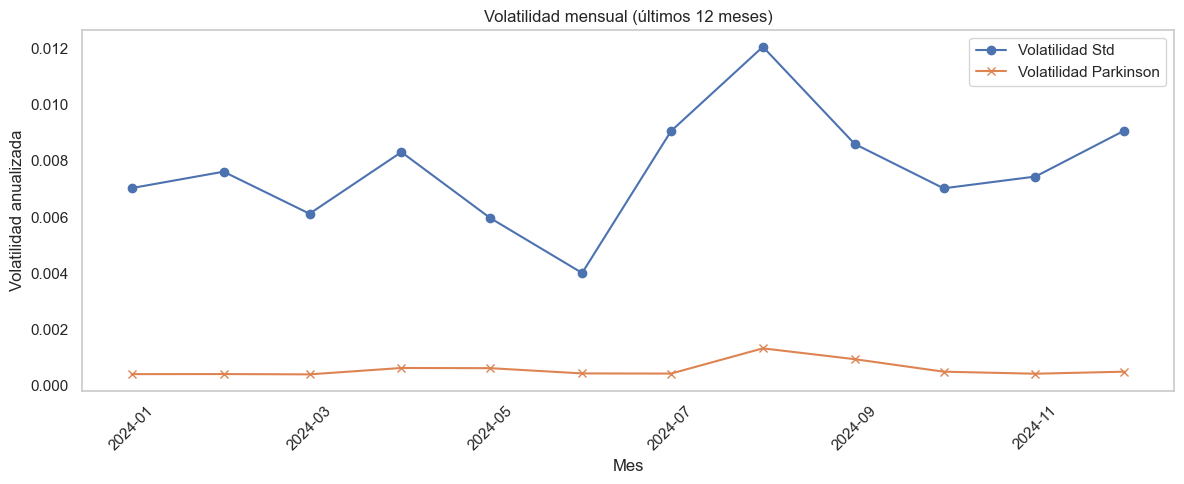

In [131]:
import pandas as pd
import matplotlib.pyplot as plt

# 📅 Calcular fecha 12 meses atrás
fecha_max = df.index.max()
fecha_inicio = fecha_max - pd.DateOffset(months=12)

# 🔍 Filtrar último año
ultimo_ano = df.loc[fecha_inicio:fecha_max].copy()

# 📆 Agrupar por fin de mes (usar 'M' → reemplazado por 'ME')
resumen_mensual = (
    ultimo_ano
    .resample('ME')  # 'ME' = month end
    .agg({
        'ret_log': ['std', 'sum', 'count'],
        'atr_14': 'mean',
        'parkinson_vol': 'mean'
    })
)

# 🧾 Renombrar columnas
resumen_mensual.columns = ['Volatilidad STD', 'Retorno Total', 'Días', 'ATR Medio', 'Vol. Parkinson']
resumen_mensual.index = resumen_mensual.index.to_period('M')

# # 📊 Mostrar tabla en consola
# print("📅 Resumen mensual de la volatilidad (últimos 12 meses):\n")
# print(resumen_mensual)

# 📈 Graficar volatilidad mensual
plt.figure(figsize=(12, 5))
plt.plot(resumen_mensual.index.to_timestamp(), resumen_mensual['Volatilidad STD'], marker='o', label='Volatilidad Std')
plt.plot(resumen_mensual.index.to_timestamp(), resumen_mensual['Vol. Parkinson'], marker='x', label='Volatilidad Parkinson')
plt.title("Volatilidad mensual (últimos 12 meses)")
plt.xlabel("Mes")
plt.ylabel("Volatilidad anualizada")
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()




Análisis del gráfico: Volatilidad mensual del SP500 (últimos 12 meses)
🔹 Ejes:
Eje X (horizontal): cada punto representa un mes, desde enero 2024 hasta diciembre 2024.

Eje Y (vertical): representa la volatilidad anualizada. Es decir, cuánto varían los retornos diarios durante un mes, extrapolado al año.

Un valor de 0.01 (~1%) implica que la desviación estándar diaria es ~0.63%, lo que se traduce en una volatilidad anual de ~1%.

🔸 Líneas:
Línea azul (Volatilidad Std): muestra la desviación estándar de los retornos logarítmicos diarios en cada mes, anualizada.

Línea naranja (Volatilidad Parkinson): representa una medida alternativa de volatilidad que usa solo los máximos y mínimos diarios, también anualizada.

In [132]:
print("🔎 Valor medio volatilidad STD:", resumen_mensual['Volatilidad STD'].mean())
print("🔎 Valor medio volatilidad Parkinson:", resumen_mensual['Vol. Parkinson'].mean())


🔎 Valor medio volatilidad STD: 0.007697246834915537
🔎 Valor medio volatilidad Parkinson: 0.0005864205875846414


📌 Promedio volatilidad diaria (último mes):
• Std anualizada: 0.147596782601575
• Parkinson anualizada: 0.0004980248765092437


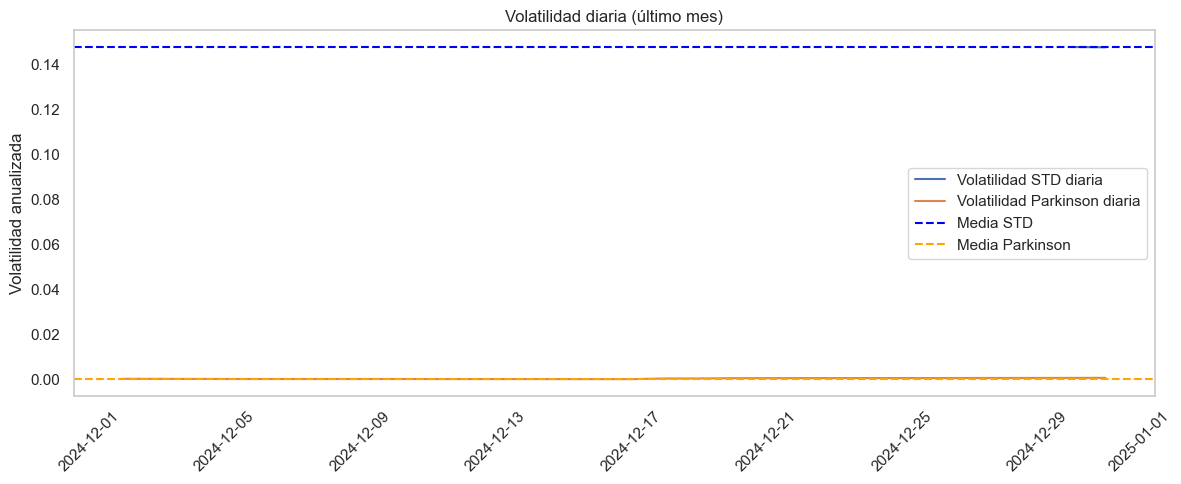

In [133]:
# 🔍 Extraer último mes de datos
ultimo_mes = df.loc[df.index >= df.index.max() - pd.DateOffset(days=31)].copy()

# 🧮 Promedios diarios
media_std = ultimo_mes['ret_log'].rolling(window=20).std() * np.sqrt(252)
media_parkinson = ultimo_mes['parkinson_vol']

# 📈 Valor medio
print("📌 Promedio volatilidad diaria (último mes):")
print("• Std anualizada:", media_std.mean())
print("• Parkinson anualizada:", media_parkinson.mean())

# 📉 Gráfico diario último mes
plt.figure(figsize=(12, 5))
plt.plot(media_std.index, media_std, label="Volatilidad STD diaria")
plt.plot(media_parkinson.index, media_parkinson, label="Volatilidad Parkinson diaria")
plt.axhline(media_std.mean(), color='blue', linestyle='--', label="Media STD")
plt.axhline(media_parkinson.mean(), color='orange', linestyle='--', label="Media Parkinson")
plt.title("Volatilidad diaria (último mes)")
plt.ylabel("Volatilidad anualizada")
plt.grid()
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


📌 Promedio volatilidad diaria (último mes):
• Std anualizada: 0.147596782601575
• Parkinson anualizada: 0.0004980248765092437


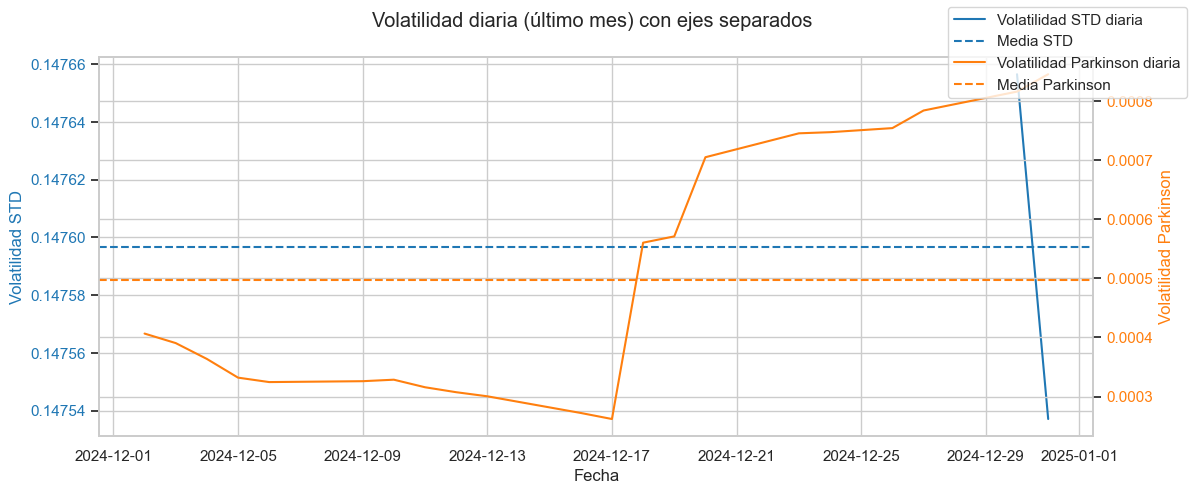

In [135]:
# 🔍 Extraer último mes de datos
ultimo_mes = df.loc[df.index >= df.index.max() - pd.DateOffset(days=31)].copy()

# 🧮 Promedios diarios
media_std = ultimo_mes['ret_log'].rolling(window=20).std() * np.sqrt(252)
media_parkinson = ultimo_mes['parkinson_vol']

# 📈 Valor medio
print("📌 Promedio volatilidad diaria (último mes):")
print("• Std anualizada:", media_std.mean())
print("• Parkinson anualizada:", media_parkinson.mean())

fig, ax1 = plt.subplots(figsize=(12, 5))

color_std = 'tab:blue'
color_park = 'tab:orange'

# Primer eje (STD)
ax1.set_xlabel("Fecha")
ax1.set_ylabel("Volatilidad STD", color=color_std)
ax1.plot(media_std.index, media_std, color=color_std, label="Volatilidad STD diaria")
ax1.axhline(media_std.mean(), color=color_std, linestyle='--', label="Media STD")
ax1.tick_params(axis='y', labelcolor=color_std)

# Segundo eje (Parkinson)
ax2 = ax1.twinx()
ax2.set_ylabel("Volatilidad Parkinson", color=color_park)
ax2.plot(media_parkinson.index, media_parkinson, color=color_park, label="Volatilidad Parkinson diaria")
ax2.axhline(media_parkinson.mean(), color=color_park, linestyle='--', label="Media Parkinson")
ax2.tick_params(axis='y', labelcolor=color_park)

# Título y leyenda
fig.suptitle("Volatilidad diaria (último mes) con ejes separados")
fig.tight_layout()
fig.legend(loc="upper right")
plt.show()



In [138]:
def detectar_columna(df, base):
    """Devuelve la primera columna que contiene la palabra base, sin importar sufijos"""
    for col in df.columns:
        if base.lower() in col.lower():
            return col
    raise KeyError(f"No se encontró una columna para '{base}'")

# 📂 Cargar tu archivo Parquet
file_path = "data/1d/spy_1d.parquet"
df = pd.read_parquet(file_path)

# 🔧 Aplanar columnas MultiIndex si es necesario
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [' '.join(filter(None, map(str, col))).strip() for col in df.columns]

# 🔎 Detectar columnas clave
high_col = detectar_columna(df, "High")
low_col = detectar_columna(df, "Low")
close_col = detectar_columna(df, "Close")

# 📅 Detectar columna de fecha
date_col = detectar_columna(df, "Date")
df.rename(columns={date_col: "Date"}, inplace=True)
df["Date"] = pd.to_datetime(df["Date"])
df.set_index("Date", inplace=True)

# 📊 Cálculo de métricas para trading
def calcular_volatilidad_trading(df, high_col, low_col, close_col, window=14):
    high = df[high_col]
    low = df[low_col]
    close_prev = df[close_col].shift(1)

    tr = np.maximum(high - low, np.maximum(abs(high - close_prev), abs(low - close_prev)))
    atr = tr.rolling(window=window).mean()
    atr_pct = atr / df[close_col]

    ret_log = np.log(df[close_col] / df[close_col].shift(1))
    std_ret_log = ret_log.rolling(window=window).std()
    vol_std_annual = std_ret_log.iloc[-1] * np.sqrt(252)

    parkinson = (1 / (4 * np.log(2))) * (np.log(high / low) ** 2)
    parkinson_vol = parkinson.rolling(window=window).mean() * np.sqrt(252)

    return {
        'ATR ($)': atr.iloc[-1],
        'ATR (%)': atr_pct.iloc[-1],
        'Vol STD anualizada': vol_std_annual,
        'Vol Parkinson anualizada': parkinson_vol.iloc[-1]
    }

# 🔍 Aplicar función
resultados = calcular_volatilidad_trading(df, high_col, low_col, close_col)

# 📋 Mostrar resultados
for k, v in resultados.items():
    print(f"{k}: {v:.6f}")


ATR ($): 7.761520
ATR (%): 0.013283
Vol STD anualizada: 0.173358
Vol Parkinson anualizada: 0.001154


📁 Usando archivo: data/1m/spy_1m_2025-05-28_1205.parquet


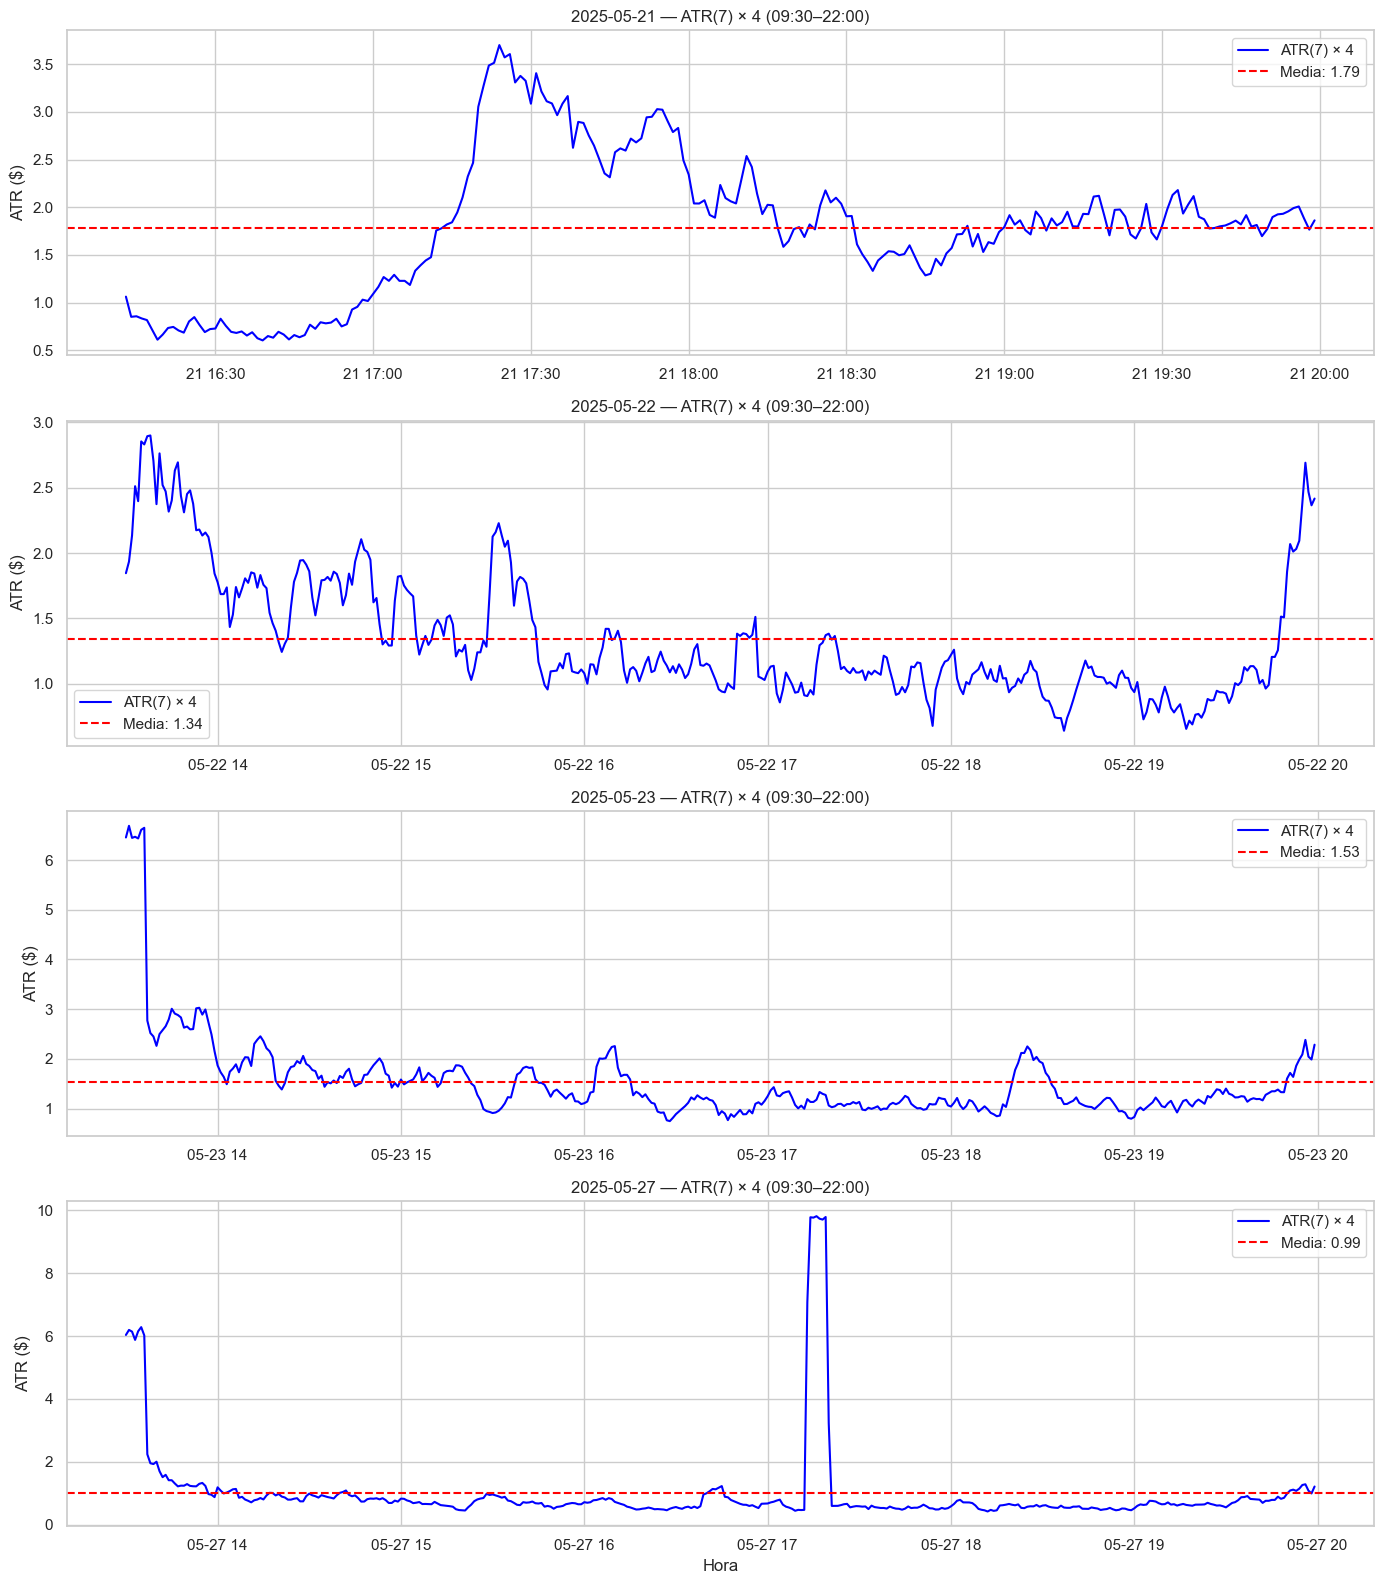

In [159]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# 🔹 Ruta al archivo más reciente de 1m
file_path = "data/1m/spy_1m_2025-05-28_1205.parquet"
print(f"📁 Usando archivo: {file_path}")

# 🔹 Leer y aplanar columnas si es MultiIndex
df = pd.read_parquet(file_path)
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [' '.join(col).strip() for col in df.columns]

# 🔍 Buscar y renombrar columna 'Datetime' correctamente
datetime_col = [col for col in df.columns if 'datetime' in col.lower()]
if not datetime_col:
    raise KeyError("❌ No se encontró ninguna columna tipo 'Datetime'")
df.rename(columns={datetime_col[0]: 'Datetime'}, inplace=True)

# 🕒 Convertir a datetime e indexar
df['Datetime'] = pd.to_datetime(df['Datetime'])
df.set_index('Datetime', inplace=True)

# 🔧 Filtrar columnas necesarias y aplanar nombres tipo 'High SPY'
for col in df.columns:
    if 'high' in col.lower(): high_col = col
    if 'low' in col.lower(): low_col = col
    if 'close' in col.lower(): close_col = col

# 🧮 Calcular ATR(7) × 4
df['prev_close'] = df[close_col].shift(1)
df['tr'] = np.maximum(df[high_col] - df[low_col],
                      np.maximum(abs(df[high_col] - df['prev_close']),
                                 abs(df[low_col] - df['prev_close'])))
df['atr7'] = df['tr'].rolling(window=7).mean()
df['atr7_x4'] = df['atr7'] * 4

# 🕓 Filtrar solo el horario de sesión regular de NY (15:30 a 22:00 hora España)
df = df.between_time("09:30", "22:00")

# 📅 Separar por día y graficar individualmente
dias = df.index.normalize().unique()

fig, axes = plt.subplots(len(dias), 1, figsize=(14, 4 * len(dias)), sharex=False)

if len(dias) == 1:
    axes = [axes]

for ax, dia in zip(axes, dias):
    diario = df[df.index.normalize() == dia]
    media_dia = diario['atr7_x4'].mean()
    ax.plot(diario.index, diario['atr7_x4'], label='ATR(7) × 4', color='blue')
    ax.axhline(y=media_dia, linestyle='--', color='red', label=f'Media: {media_dia:.2f}')
    ax.set_title(f"{dia.date()} — ATR(7) × 4 (09:30–22:00)")
    ax.set_ylabel("ATR ($)")
    ax.legend()
    ax.grid(True)

plt.xlabel("Hora")
plt.tight_layout()
plt.show()


📁 Usando archivo: data/1m/spy_1m_2025-05-28_1205.parquet


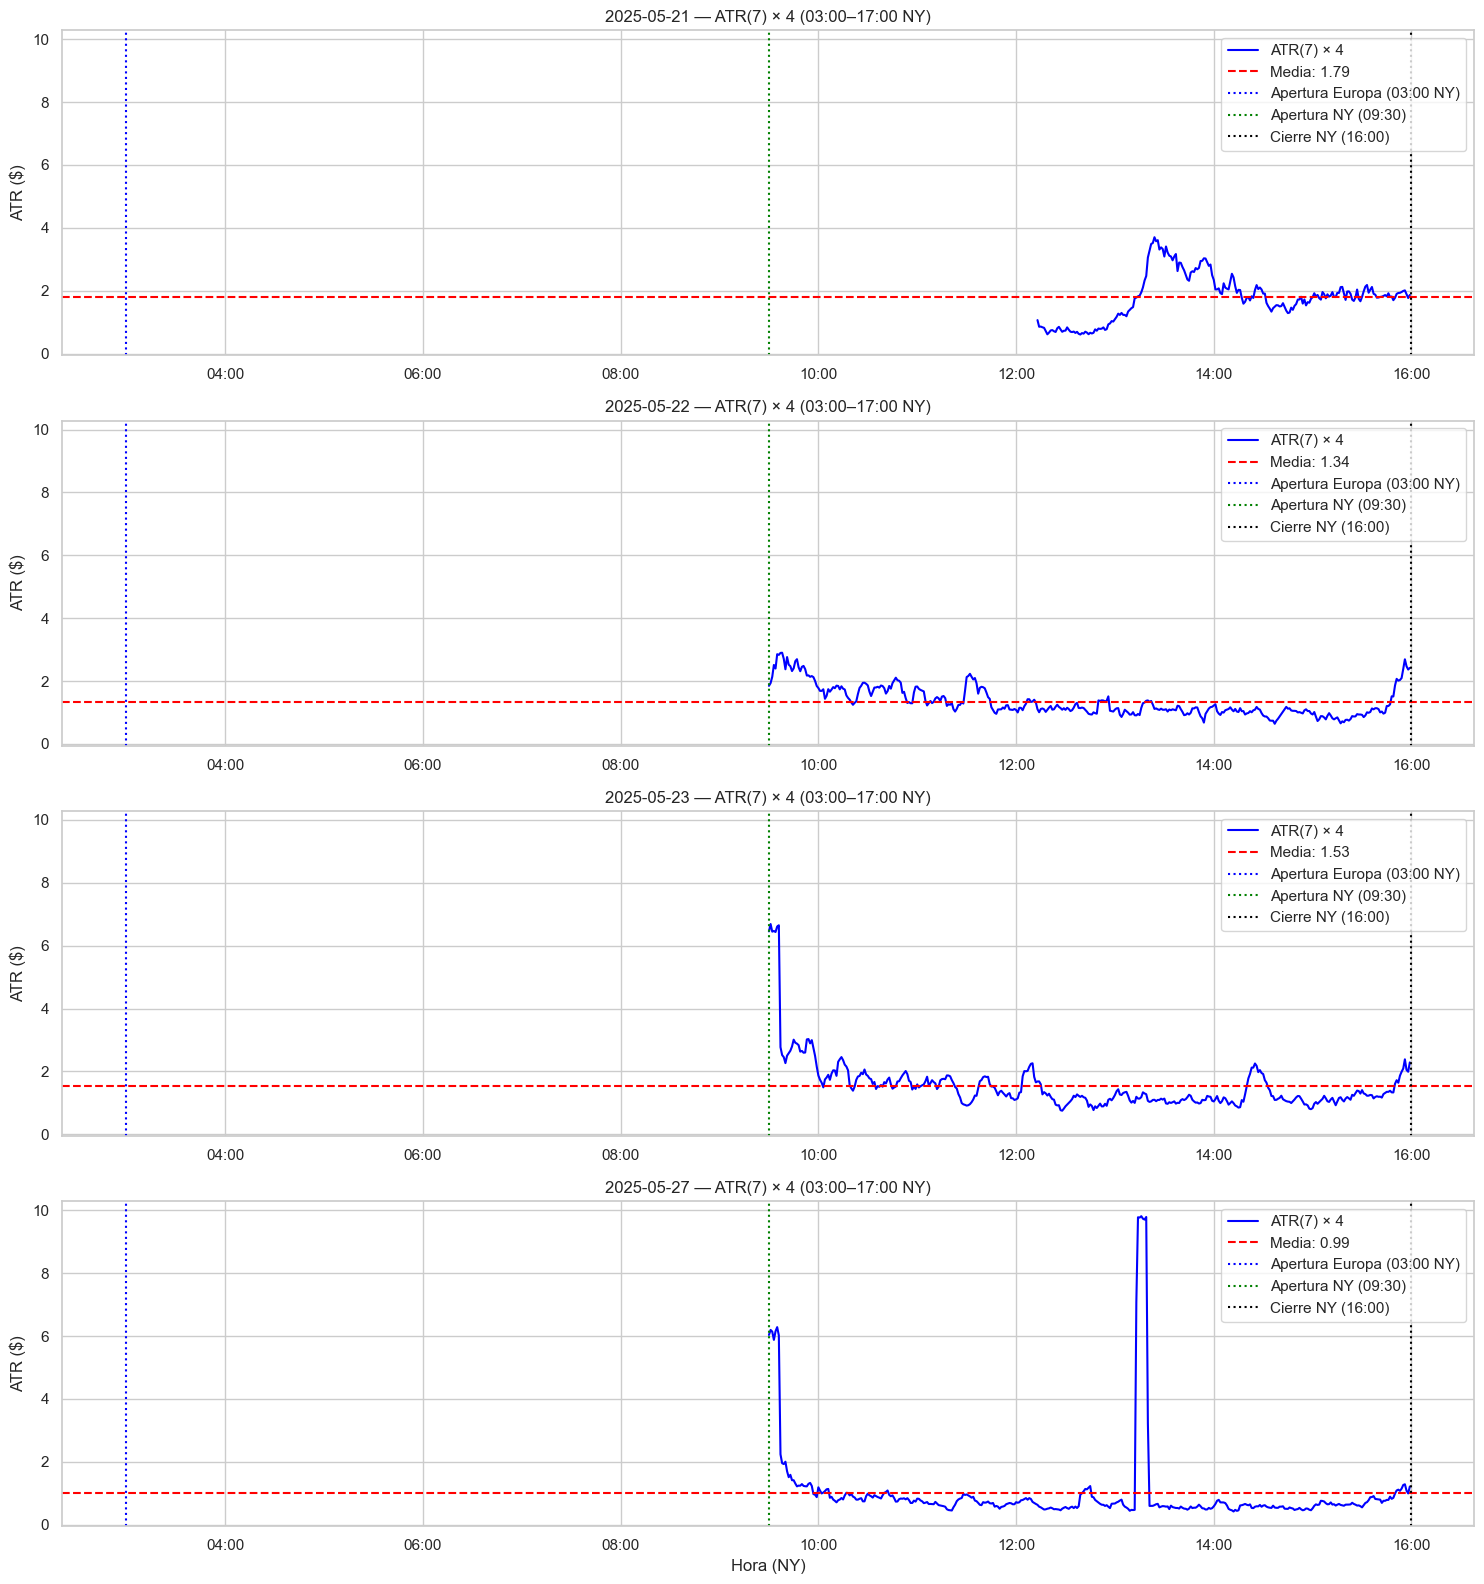

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import pytz

# CONFIGURACIÓN
file_path = "data/1m/spy_1m_2025-05-28_1205.parquet"
print(f"📁 Usando archivo: {file_path}")

# LECTURA Y PREPARACIÓN
df = pd.read_parquet(file_path)

# Aplanar columnas si es MultiIndex
if isinstance(df.columns, pd.MultiIndex):
    df.columns = [' '.join(col).strip() for col in df.columns]

# Buscar columnas relevantes automáticamente
def encontrar_col(nombre):
    return next((col for col in df.columns if nombre.lower() in col.lower()), None)

datetime_col = encontrar_col("datetime")
close_col = encontrar_col("close")
high_col = encontrar_col("high")
low_col = encontrar_col("low")

if not all([datetime_col, close_col, high_col, low_col]):
    raise KeyError("❌ Faltan columnas necesarias: datetime, close, high o low")

# Preparar DataFrame
df.rename(columns={datetime_col: "Datetime"}, inplace=True)
df['Datetime'] = pd.to_datetime(df["Datetime"], utc=True)
df.set_index("Datetime", inplace=True)
df.index = df.index.tz_convert("America/New_York")

# FILTRAR HORARIO 03:00 a 17:00 NY
df = df.between_time("03:00", "17:00")
df["fecha_ny"] = df.index.date

# CÁLCULO ATR(7) × 4
df["prev_close"] = df[close_col].shift(1)
df["tr"] = np.maximum(df[high_col] - df[low_col],
                      np.maximum(abs(df[high_col] - df["prev_close"]),
                                 abs(df[low_col] - df["prev_close"])))
df["atr7"] = df["tr"].rolling(window=7).mean()
df["atr7x4"] = df["atr7"] * 4

# ÚLTIMOS 6 DÍAS
ultimos_dias = sorted(df["fecha_ny"].unique())[-6:]

# GRÁFICO POR DÍA
fig, axes = plt.subplots(len(ultimos_dias), 1, figsize=(15, 4 * len(ultimos_dias)), sharey=True)
if len(ultimos_dias) == 1:
    axes = [axes]

for ax, dia in zip(axes, ultimos_dias):
    diario = df[df["fecha_ny"] == dia]
    if diario.empty:
        continue

    media = diario["atr7x4"].mean()
    ax.plot(diario.index, diario["atr7x4"], color="blue", label="ATR(7) × 4")
    ax.axhline(media, color="red", linestyle="--", label=f"Media: {media:.2f}")

    # Líneas verticales clave
    zona = "America/New_York"
    apertura_eu = pd.Timestamp(f"{dia} 03:00", tz=zona)
    apertura_ny = pd.Timestamp(f"{dia} 09:30", tz=zona)
    cierre_ny = pd.Timestamp(f"{dia} 16:00", tz=zona)

    ax.axvline(apertura_eu, color="blue", linestyle=":", label="Apertura Europa (03:00 NY)")
    ax.axvline(apertura_ny, color="green", linestyle=":", label="Apertura NY (09:30)")
    ax.axvline(cierre_ny, color="black", linestyle=":", label="Cierre NY (16:00)")

    ax.set_title(f"{dia} — ATR(7) × 4 (03:00–17:00 NY)")
    ax.set_ylabel("ATR ($)")
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M', tz=pytz.timezone("America/New_York")))
    ax.legend()
    ax.grid(True)

plt.xlabel("Hora (NY)")
plt.tight_layout()
plt.show()







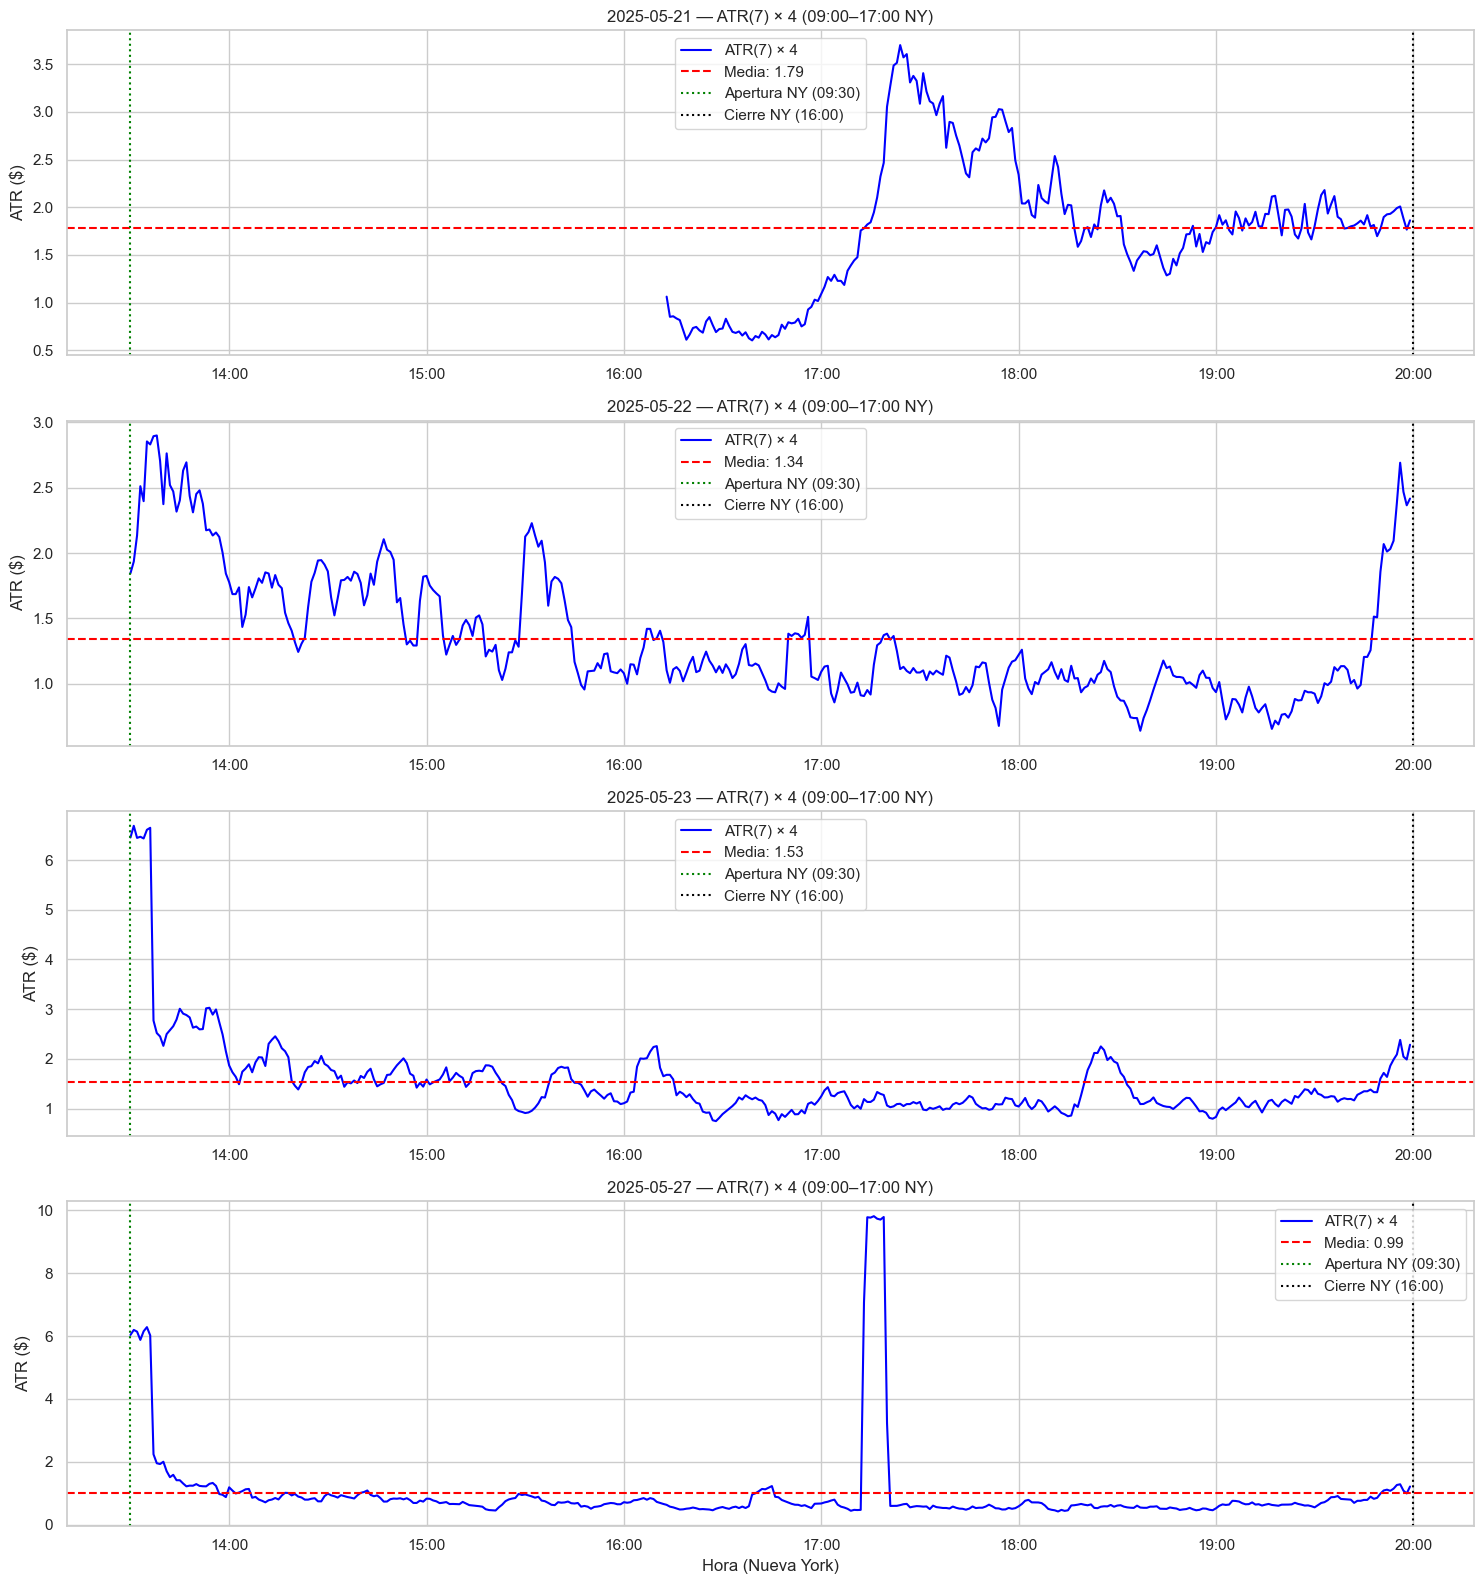

In [171]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import os

# ============================
# CONFIGURACIÓN
# ============================
ticker = "SPY"
ruta = "data/1m/spy_1m_2025-05-28_1205.parquet"

# ============================
# LECTURA Y PREPARACIÓN
# ============================
df = pd.read_parquet(ruta)

# Aplanar columnas si MultiIndex
df.columns = [' '.join(col).strip() if isinstance(col, tuple) else col for col in df.columns]
df.columns = [col.replace(f" {ticker}", "").strip() for col in df.columns]

# Convertir 'Datetime' y establecer índice
datetime_col = [col for col in df.columns if 'datetime' in col.lower()]
if not datetime_col:
    raise KeyError("❌ No se encontró ninguna columna tipo 'Datetime'")
df.rename(columns={datetime_col[0]: 'Datetime'}, inplace=True)
df['Datetime'] = pd.to_datetime(df['Datetime'], utc=True)
df.set_index('Datetime', inplace=True)

# Convertir a hora NY
df.index = df.index.tz_convert("America/New_York")

# ============================
# CÁLCULO DEL ATR(7) × 4
# ============================
for col in df.columns:
    if 'close' in col.lower(): close_col = col
    if 'high' in col.lower(): high_col = col
    if 'low' in col.lower(): low_col = col

df['prev_close'] = df[close_col].shift(1)
df['tr'] = np.maximum(df[high_col] - df[low_col],
                      np.maximum(abs(df[high_col] - df['prev_close']),
                                 abs(df[low_col] - df['prev_close'])))
df['atr7'] = df['tr'].rolling(window=7).mean()
df['atr7_x4'] = df['atr7'] * 4

# ============================
# FILTRO: 09:00 a 17:00 NY
# ============================
df = df.between_time("09:00", "17:00")

# ============================
# GRÁFICO POR DÍA
# ============================
dias = df.index.normalize().unique()
fig, axes = plt.subplots(len(dias), 1, figsize=(15, 4 * len(dias)), sharex=False)

if len(dias) == 1:
    axes = [axes]

for ax, dia in zip(axes, dias):
    diario = df[df.index.normalize() == dia]
    media_dia = diario['atr7_x4'].mean()

    ax.plot(diario.index, diario['atr7_x4'], label='ATR(7) × 4', color='blue')
    ax.axhline(media_dia, color='red', linestyle='--', label=f"Media: {media_dia:.2f}")

    # Líneas verticales informativas
    apertura = pd.Timestamp(f"{dia.date()} 09:30", tz="America/New_York")
    cierre = pd.Timestamp(f"{dia.date()} 16:00", tz="America/New_York")
    ax.axvline(apertura, linestyle=":", color="green", label="Apertura NY (09:30)")
    ax.axvline(cierre, linestyle=":", color="black", label="Cierre NY (16:00)")

    ax.set_title(f"{dia.date()} — ATR(7) × 4 (09:00–17:00 NY)")
    ax.set_ylabel("ATR ($)")
    ax.legend()
    ax.grid(True)
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

plt.xlabel("Hora (Nueva York)")
plt.tight_layout()
plt.show()
